# Dependencies

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=9292edcdf4d63181d3e460586f9431cc5b81ca9b7f71069adf9276ca6ad38cd2
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools


# Libraries

In [ ]:
from typing import List


In [ ]:
import gc
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import torch
import torchvision as tv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, KFold
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.notebook import tqdm

import wandb

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [ ]:
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_S_Weights.DEFAULT

TRAIN_IMAGES_PATH = '/content/rnsa_cervical_spine_fracture_detection/train_images'
TEST_IMAGES_PATH = '/content/rnsa_cervical_spine_fracture_detection/test_images'
METADATA_PATH = '/content/rnsa_cervical_spine_fracture_detection/metadata'
EFFNET_CHECKPOINTS_PATH = '/content/rnsa_cervical_spine_fracture_detection/chkpts'

EFFNET_MAX_TRAIN_BATCHES = 10000
EFFNET_MAX_EVAL_BATCHES = 1000
ONE_CYCLE_MAX_LR = 0.0004
ONE_CYCLE_PCT_START = 0.3
SAVE_CHECKPOINT_EVERY_STEP = 500
N_MODELS_FOR_INFERENCE = 2

os.environ['WANDB_API_KEY'] = '44e8b9bf7e182327bfb2003ed06792ea184aac37'
# 44e8b9bf7e182327bfb2003ed06792ea184aac37

print(torch.cuda.is_available())

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 2

N_FOLDS = 5

True


Text(0.5, 1.0, 'jpeg')

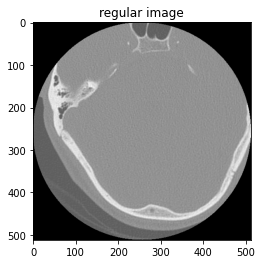

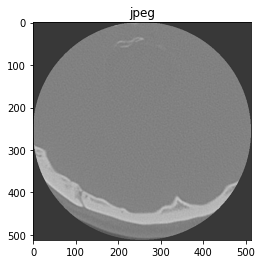

In [ ]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data=(data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img


im, meta = load_dicom(f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10001/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('regular image')

im, meta = load_dicom(f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10014/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('jpeg')

In [ ]:
import pandas as pd
df_seg = pd.read_csv(f'{METADATA_PATH}/meta_segmentation.csv')

split = GroupKFold(N_FOLDS)
for k, (train_idx, test_idx) in enumerate(split.split(df_seg, groups=df_seg.StudyInstanceUID)):
    df_seg.loc[test_idx, 'split'] = k

split = KFold(N_FOLDS)
for k, (train_idx, test_idx) in enumerate(split.split(df_seg)):
    df_seg.loc[test_idx, 'random_split'] = k

slice_max_seg = df_seg.groupby('StudyInstanceUID')['Slice'].max().to_dict()
df_seg['SliceRatio'] = 0
df_seg['SliceRatio'] = df_seg['Slice'] / df_seg['StudyInstanceUID'].map(slice_max_seg)

df_seg.sample(10)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,split,random_split,SliceRatio
3601,1.2.826.0.1.3680043.1542,19,512,512,0.600,-95.346680,-245.846680,-1197.300000,0,0,0,0,0,0,0,4.0,0.0,0.044393
20899,1.2.826.0.1.3680043.31077,15,512,512,0.600,-99.305664,-205.895664,-897.100000,0,0,0,0,0,0,0,1.0,3.0,0.022321
4118,1.2.826.0.1.3680043.1573,108,512,512,1.000,-83.586400,-56.711430,-553.600000,0,1,0,0,0,0,0,2.0,0.0,0.377622
438,1.2.826.0.1.3680043.10921,10,512,512,0.625,-67.400000,-85.000000,-4.625000,0,0,0,0,0,0,0,0.0,0.0,0.029499
26576,1.2.826.0.1.3680043.5782,328,512,512,0.600,-102.331055,-247.831055,-1065.800000,0,0,0,1,1,0,0,1.0,4.0,0.576450
9742,1.2.826.0.1.3680043.20928,138,512,512,1.000,-77.971100,-83.596190,-559.600000,0,0,1,1,0,0,0,4.0,1.0,0.556452
25862,1.2.826.0.1.3680043.5671,47,512,512,1.000,-74.210526,127.789474,883.599945,0,0,0,0,0,0,0,4.0,4.0,0.108545
22412,1.2.826.0.1.3680043.32370,162,512,512,1.000,-79.207700,-86.082760,-628.300000,0,0,0,1,1,1,0,2.0,3.0,0.618321
4844,1.2.826.0.1.3680043.16919,219,512,512,1.000,-65.394736,68.136842,536.700012,0,0,0,1,1,0,0,1.0,0.0,0.535452
602,1.2.826.0.1.3680043.10921,174,512,512,0.625,-67.400000,-85.000000,-107.125000,0,0,0,0,1,0,0,0.0,0.0,0.513274


In [ ]:
class VertebraeSegmentDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):
        path = os.path.join(self.path, self.df.iloc[i].StudyInstanceUID, f'{self.df.iloc[i].Slice}.dcm')
        try:
            img = load_dicom(path)[0]
            img = np.transpose(img, (2, 0, 1))  # Pytorch uses (batch, channel, height, width) order. Converting (height, width, channel) -> (channel, height, width)
            if self.transforms is not None:
                img = self.transforms(torch.as_tensor(img))
        except Exception as ex:
            print(ex)
            return None

        if 'C1' in self.df.columns:
            vert_targets = torch.as_tensor(self.df.iloc[i][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].astype('float32').values)
            return img, vert_targets
        return img

    def __len__(self):
        return len(self.df)


ds_seg = VertebraeSegmentDataSet(df_seg, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
X, y = ds_seg[300]
X.shape, y.shape

(torch.Size([3, 384, 384]), torch.Size([7]))

In [ ]:
class SegEffnetModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        effnet = tv.models.efficientnet_v2_s(weights=WEIGHTS)
        self.model = create_feature_extractor(effnet, ['flatten'])
        self.nn_vertebrae = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )
    
    def forward(self, x):
        x = self.model(x)['flatten']
        return self.nn_vertebrae(x)
    
    def predict(self, x):
        pred = self.forward(x)
        return torch.sigmoid(pred)
    
# path of model downloaded /Users/jarvis/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
model = SegEffnetModel()
model.predict(torch.randn(1, 3, 512, 512))
        

tensor([[0.5003, 0.5266, 0.4996, 0.4952, 0.4943, 0.5337, 0.5262]],
       grad_fn=<SigmoidBackward0>)

In [ ]:
del model

In [ ]:
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
def filter_nones(b):
    return torch.utils.data.default_collate([v for v in b if v is not None])

In [ ]:
def save_model(name, model, optim, scheduler):
    torch.save({
        'model': model.state_dict(),
        'optim': optim.state_dict(),
        'scheduler': scheduler
    }, f'{EFFNET_CHECKPOINTS_PATH}/{name}.tph')

def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{EFFNET_CHECKPOINTS_PATH}/{name}.tph'), map_location=DEVICE)
    model.load_state_dict(data['model'])
    optim = torch.optim.Adam(model.parameters())
    optim.load_state_dict(data['optim'])
    return model, optim, data['scheduler']

# quick test
model = torch.nn.Linear(2, 1)
optim = torch.optim.Adam(model.parameters())
save_model('testmodel', model, optim, None)

model1, optim1, scheduler1 = load_model(torch.nn.Linear(2, 1), 'testmodel')
assert torch.all(next(iter(model1.parameters())) == next(iter(model.parameters()))).item(), "Loading/saving is inconsistent!"

In [ ]:
def evaluate_segeffnet(model: SegEffnetModel, ds, max_batches=1e9, shuffle=False):
    torch.manual_seed(42)
    model = model.to(DEVICE)
    # dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=os.cpu_count(), collate_fn=filter_nones)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, collate_fn=filter_nones)

    with torch.no_grad():
        model.eval()
        pred = []
        y = []
        progress = tqdm(dl_test, desc='Eval', miniters=100)
        for i, (X, y_vert) in enumerate(progress):
            # with autocast():
            y_vert_pred = model.predict(X.to(DEVICE))
            pred.append(y_vert_pred.cpu().numpy())
            y.append(y_vert.numpy())
            acc = np.mean(np.mean((pred[-1] > 0.5) == y[-1], axis=0))
            progress.set_description(f'Eval acc: {acc: .02f}')
            if i >= max_batches:
                break
        pred = np.concatenate(pred)
        y = np.concatenate(y)
        acc = np.mean(np.mean((pred > 0.5) == y, axis=0))
        return acc, pred

In [ ]:

import wandb
os.environ['WANDB_NOTEBOOK_NAME'] = 'c1-c7_extraction_ai.ipynb'
wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find c1-c7_extraction_ai.ipynb.
wandb: Currently logged in as: hawkeye05 (team-fyp). Use `wandb login --relogin` to force relogin


True

In [ ]:
%%wandb


def train_segeffnet(ds_train, ds_eval, logger, name):
    torch.manual_seed(42)
    # dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), collate_fn=filter_nones)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=filter_nones)

    model = SegEffnetModel().to(DEVICE)
    optim = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=ONE_CYCLE_MAX_LR, epochs=1, steps_per_epoch=min(EFFNET_MAX_TRAIN_BATCHES, len(dl_train)), pct_start=ONE_CYCLE_PCT_START)
    model.train()
    scaler = GradScaler()

    progress = tqdm(dl_train, desc='Train', miniters=10)
    for batch_idx, (X,  y_vert) in enumerate(progress):

        if batch_idx % SAVE_CHECKPOINT_EVERY_STEP == 0 and EFFNET_MAX_EVAL_BATCHES > 0:
            eval_loss = evaluate_segeffnet(model, ds_eval, max_batches=EFFNET_MAX_EVAL_BATCHES, shuffle=True)[0]
            model.train()
            if logger is not None:
                logger.log({'eval_acc': eval_loss})
            if batch_idx > 0:  # don't save untrained model
                save_model(name, model, optim, scheduler)

        if batch_idx >= EFFNET_MAX_TRAIN_BATCHES:
            break

        optim.zero_grad()
        with autocast():
            y_vert_pred = model.forward(X.to(DEVICE))
            loss = torch.nn.functional.binary_cross_entropy_with_logits(y_vert_pred, y_vert.to(DEVICE))

            if np.isinf(loss.item()) or np.isnan(loss.item()):
                print(f'Bad loss, skipping the batch {batch_idx}')
                del y_vert_pred, loss
                gc_collect()
                continue

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        scheduler.step()

        progress.set_description(f'Train loss: {loss.item():.02f}')
        if logger is not None:
            logger.log({'loss': loss.item(), 'lr': scheduler.get_last_lr()[0]})


    eval_loss = evaluate_segeffnet(model, ds_eval, max_batches=EFFNET_MAX_EVAL_BATCHES, shuffle=True)[0]
    if logger is not None:
        logger.log({'eval_acc': eval_loss})

    save_model(name, model, optim, scheduler)
    return model


seg_models = []
for fold in range(N_FOLDS):
    fname = os.path.join(f'{EFFNET_CHECKPOINTS_PATH}/segeffnetv2-f{fold}.tph')
    if os.path.exists(fname):
        print(f'Found cached model {fname}')
        seg_models.append(load_model(SegEffnetModel(), f'segeffnetv2-f{fold}', EFFNET_CHECKPOINTS_PATH)[0].to(DEVICE))
    else:
        with wandb.init(project='CERVICAL_DETECTION', name=f'SegEffNet-v2-fold{fold}') as run:
            gc_collect()
            ds_train = VertebraeSegmentDataSet(df_seg.query('split != @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
            ds_eval = VertebraeSegmentDataSet(df_seg.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
            train_segeffnet(ds_train, ds_eval, run, f'segeffnetv2-f{fold}')

Found cached model /content/rnsa_cervical_spine_fracture_detection/chkpts/segeffnetv2-f0.tph
Found cached model /content/rnsa_cervical_spine_fracture_detection/chkpts/segeffnetv2-f1.tph
Found cached model /content/rnsa_cervical_spine_fracture_detection/chkpts/segeffnetv2-f2.tph
Found cached model /content/rnsa_cervical_spine_fracture_detection/chkpts/segeffnetv2-f3.tph
Found cached model /content/rnsa_cervical_spine_fracture_detection/chkpts/segeffnetv2-f4.tph


In [ ]:
# print(seg_models)
with tqdm(seg_models, desc='Fold') as progress:
    for fold, model in enumerate(progress):
        ds = VertebraeSegmentDataSet(df_seg.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
        acc, pred = evaluate_segeffnet(model, ds, max_batches=1e9, shuffle=False)
        df_seg.loc[df_seg[df_seg.split == fold].index, ['C1_pred', 'C2_pred', 'C3_pred', 'C4_pred', 'C5_pred', 'C6_pred', 'C7_pred']] = pred
        progress.set_description(f'Acc: {acc}')

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/190 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/190 [00:00<?, ?it/s]

In [ ]:
ds = VertebraeSegmentDataSet(df_seg.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
# df_train.head()

In [ ]:
acc = (df_seg[[f'C{i}_pred' for i in range(1, 8)]] > 0.5).values == (df_seg[[f'C{i}' for i in range(1, 8)]] > 0.5).values
print('Effnetv2 accuracy per vertebrae', np.mean(acc, axis=0))
print('Effnetv2 average accuracy', np.mean(np.mean(acc, axis=0)))

Effnetv2 accuracy per vertebrae [0.96111558 0.9414052  0.95850094 0.95974122 0.94924913 0.94686913
 0.94656744]
Effnetv2 average accuracy 0.9519212351070757


In [ ]:
def predict_vertebrae(df, seg_models: List[SegEffnetModel]):
    df = df.copy()
    ds = VertebraeSegmentDataSet(df, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
    # dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), collate_fn=filter_nones)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=filter_nones)

    predictions = []
    with torch.no_grad():
        with tqdm(dl_test, desc='Eval', miniters=10) as progress:
            for i, X in enumerate(progress):
                with autocast():
                    pred = torch.zeros(len(X), 7).to(DEVICE)
                    for model in seg_models:
                        pred += model.predict(X.to(DEVICE)) / len(seg_models)
                        # print(model.predict(X.to(DEVICE)))
                    predictions.append(pred)
    predictions = torch.concat(predictions).cpu().numpy()
    return predictions

In [ ]:
df_train = pd.read_csv(os.path.join(METADATA_PATH, 'meta_train_clean.csv'))
df_train.head()
# df_train_1 = pd.read_csv(os.path.join(METADATA_PATH, 'meta_train_clean_1.csv'))
# df_train_2 = pd.read_csv(os.path.join(METADATA_PATH, 'meta_train_clean_2.csv'))

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032
3,1.2.826.0.1.3680043.10001,4,512,512,0.625,-52.308,-27.712,5.407
4,1.2.826.0.1.3680043.10001,5,512,512,0.625,-52.308,-27.712,4.782


Eval:   0%|          | 0/21 [00:00<?, ?it/s]

Eval:   0%|          | 0/9 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

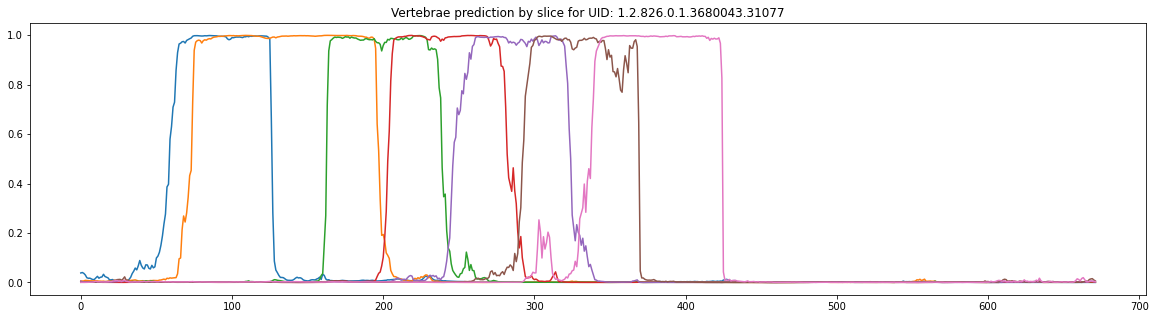

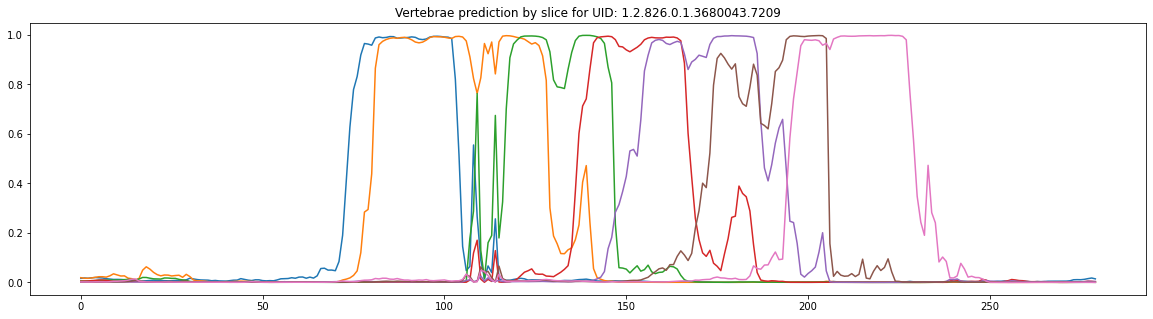

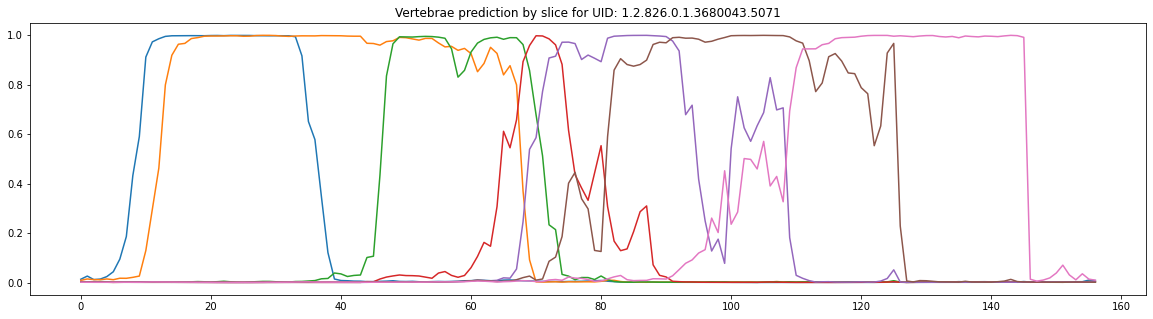

In [ ]:
for uid in np.random.choice(df_train.StudyInstanceUID, 3):
    pred = predict_vertebrae(df_train.query('StudyInstanceUID == @uid'), seg_models[:2])
    plt.figure(figsize=(20, 5))
    plt.plot(pred)
    plt.title(f'Vertebrae prediction by slice for UID: {uid}')

In [ ]:
# pred_1 = predict_vertebrae(df_train_1, seg_models[:N_MODELS_FOR_INFERENCE])

In [ ]:
pred = predict_vertebrae(df_train, seg_models[:N_MODELS_FOR_INFERENCE])

Eval:   0%|          | 0/22238 [00:00<?, ?it/s]

In [ ]:
df_train[[f'C{i}' for i in range(1, 8)]] = pred
df_train.to_csv(f'{METADATA_PATH}/train_segmented_1.csv', index=False)